# Mercado Financeiro e Gestão de Portfólio
## Construindo o juro real e o juro neutro em Python

A **taxa de juros estrutural**, também denominada **taxa de juros neutra**, é um ponto de referência para a condução da política monetária. Quando a **taxa de juros real** se encontra **abaixo** da taxa de juros estrutural, ela exerce um efeito **estimulativo** – impulsionando a atividade econômica e contribuindo para um aumento da inflação. Por outro lado, quando a **taxa de juros real** se encontra **acima** da taxa estrutural, seu efeito é **contracionista** – contém a atividade econômica e contribui para a redução da inflação.

No regime de metas para a inflação, a **política monetária deve ser conduzida para manter a inflação na meta no horizonte relevante**. Se a trajetória prospectiva da inflação indica níveis acima da meta no horizonte relevante para a política monetária, o banco central deve conduzir sua política de juros e sua comunicação de modo que as taxas de juros reais ex-ante situem-se em terreno contracionista, ou seja, acima da taxa neutra.

O oposto vale se a trajetória prospectiva da inflação aponta para níveis abaixo da meta no horizonte relevante. Nesse caso, o banco central deve conduzir sua política de juros e comunicação de modo que a política monetária se torne estimulativa.

O quão acima ou abaixo da taxa neutra o banco central deve mirar nessas circunstâncias depende, dentre outros fatores, da efetividade da transmissão da política monetária, do hiato do produto, do balanço de riscos e, de forma geral, da velocidade almejada para convergência da inflação à meta.

Uma das dificuldades na condução da política monetária decorre do fato de que a taxa de juros neutra não é observável. Portanto, esse importante ponto de referência precisa ser estimado a partir de um amplo conjunto de informações e modelos.

O método considerado nessa código será dado como:

**Juro real ex-ante**, obtido a partir do juro do swap DI 360 deflacionado pela expectativa de inflação para os próximos 12 meses.

**Juro de equilíbrio** segue uma proxy definida no Relatório de Inflação de dezembro de 2024, dada pela Selic esperada para t+3 deflacionada pela inflação esperada para t+3.

Para o cálculo, utilizamos a equação de Fisher, que nos dá a diferença entre o juro nominal e a expectativa de inflação.

Pela equação de Fisher, sabemos que

$$
i = r + \pi
$$

Onde, $i$ é a taxa de juros nominal, $r$ é a taxa de juros real e $\pi$ é a taxa de inflação. Rearranjando os termos, definimos o juro real ex-post como:

$$
r = i - \pi
$$

Para tornar a análise ex-ante, devemos substituir $\pi$ pela expectativa de inflação, isto é, $\pi^{e}$, de modo que o juro real ex-ante será dado por:

$$
r = i - \pi^{e}
$$

Em outras palavras, o juro real ex-ante será dado, de forma aproximada, pela diferença entre o juro nominal e a expectativa de inflação. Essa é, em geral, a forma como o mercado calcula a taxa de juros real no país. Em termos exatos, o cálculo se dá pela fórmula:

$$
(1+r_{t+1}) = (1+i_t)/(1+E_t\pi_{t+1})
$$

In [1]:
import numpy as np

import datetime
from datetime import datetime

!pip install python-bcb
from bcb import Expectativas

import pandas as pd

!pip install ipeadatapy
import ipeadatapy as ip

from matplotlib import pyplot as plt
import seaborn as sns

# Juro real ex-ante

Para o juro real ex-ante, é necessário obter o juro do swap DI 360 e deflacionar o seu valor pela expectativa de inflação para os próximos 12 meses.

In [2]:
# Cria uma função para a equação de fisher
def fisher(juros, inflacao):
    """
    Calcula a taxa de juros real neutra usando a equação de Fisher.

    Args:
        juros (float): A taxa de juros nominal em porcentagem (%).
        inflacao (float): A taxa de inflação em porcentagem (%).

    Returns:
        float: A taxa de juros real em porcentagem (%).

    Raises:
        TypeError: Se os argumentos `juros` e `inflacao` não forem do tipo `float`.

    Exemplo:
        >>> fisher(10, 3)
        6.796116504854364
    """
    juros = ((((1 + (juros / 100)) / (1 + inflacao / 100))) -1) * 100
    return juros

## Swaps - DI pré-360 dias

Para importar os dados do Swaps - DI pré-360 dias utilizaremos como fonte o IPEADATA/B3

In [3]:
# Taxa referencial - swaps - DI pré-360 dias - média do período (IPEADATA/B3)
swaps = (
    ip.timeseries('BMF12_SWAPDI36012')
    .rename(columns = {'VALUE ((% a.a.))' : 'swaps'})[['swaps']]
  )

# Muda a coluna de data para o índice
swaps = swaps.set_index(swaps.index.to_period('M'))

swaps

,swaps
DATE,
1999-09,25.620000
1999-10,25.020000
1999-11,23.790000
1999-12,22.680000
2000-01,21.240000
...,...
2025-07,14.720870
2025-08,14.490500
2025-09,14.351818


## Expectativa média do IPCA 12 meses

Para importar os dados da expectativa média do IPCA 12 meses utilizaremos novamente o python-bcb

In [4]:
# Instância a classe de Expectativas
em = Expectativas()

# Obtém o endpoint da Expectativa de Inflação Acumulada em 12 meses
exp_ipca_raw = em.get_endpoint('ExpectativasMercadoInflacao12Meses')

# Expectativa média do IPCA - tx. acumulada para os próximos 12 meses (Expectativas)
ipca_expec_12m_raw = (
    exp_ipca_raw.query()
    .filter(exp_ipca_raw.Suavizada == 'S',
            exp_ipca_raw.baseCalculo == 0,
            exp_ipca_raw.Indicador == 'IPCA')
    .collect()
    )

In [5]:
ipca_expec_12m_raw

,Indicador,Data,Suavizada,Media,Mediana,DesvioPadrao,Minimo,Maximo,numeroRespondentes,baseCalculo
0,IPCA,2001-12-12,S,5.1700,5.2200,0.5600,NaN,NaN,NaN,0
1,IPCA,2001-12-13,S,5.1600,5.2200,0.5500,NaN,NaN,NaN,0
2,IPCA,2001-12-14,S,5.1300,5.1500,0.5700,NaN,NaN,NaN,0
3,IPCA,2001-12-17,S,5.1200,5.1600,0.5700,NaN,NaN,NaN,0
4,IPCA,2001-12-18,S,5.0900,5.1300,0.5800,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...
6039,IPCA,2026-01-05,S,4.0721,4.0468,0.2996,3.4774,5.6799,132.0,0
6040,IPCA,2026-01-06,S,4.0756,4.0462,0.3003,3.4829,5.6977,133.0,0
6041,IPCA,2026-01-07,S,4.0748,4.0444,0.3021,3.4883,5.7156,134.0,0
6042,IPCA,2026-01-08,S,4.0754,4.0475,0.3052,3.4927,5.7335,136.0,0


In [6]:
# Muda a classe da coluna de data para date time e period, renomeia as colunas e seleciona a coluna dos valores
ipca_expec_12m = (
    ipca_expec_12m_raw
    # altera o tipo da coluna de data para datetime
    .set_index(pd.to_datetime(ipca_expec_12m_raw['Data'])
    # altera o tipo da coluna para period
    .dt.to_period('D'))
    .rename(columns = {'Mediana' : 'ipca_exp_12m'})
    .loc[:, ['ipca_exp_12m']]
    .resample('M')
    .mean()
  )

ipca_expec_12m

/tmp/ipython-input-467300777.py:10: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  .resample('M')


,ipca_exp_12m
Data,
2001-12,5.030000
2002-01,4.733636
2002-02,4.644737
2002-03,4.721500
2002-04,4.790000
...,...
2025-09,4.381309
2025-10,4.126365
2025-11,4.099695


In [7]:
# Junta o df do swap e expectativas do ipca
ex_ante = ipca_expec_12m.join(swaps)

# Calcula o juro real ex-ante
juro_real = (
    ex_ante
    .assign(juro_real = lambda x: fisher(x.swaps, x.ipca_exp_12m),
            date = lambda x: x.index.to_timestamp())
    .set_index('date')
    [['juro_real']]
)

juro_real

,juro_real
date,
2001-12-01,15.519375
2002-01-01,15.034677
2002-02-01,14.587703
2002-03-01,13.300516
2002-04-01,13.474568
...,...
2025-09-01,9.552006
2025-10-01,9.706584
2025-11-01,9.397156


## Proxy juro neutro

Para calcular o juro neutro será necessário buscar os dados da Selic Esperada em t+3, bem como os dados da inflação esperado para t+3. Portanto, abaixo, utilizamos o python-bcb para importar os dados do Boletim Focus referente as expectativas de mercado das duas variáveis, bem como realiza-se o tratamento para o ano de referência.

In [8]:
# Cria função para calcular a data de referência a partir da data de observação
def reference_date(date: str):
    """
    Calcula a data de referência adicionando 3 anos a uma data de observação.

    Args:
        date (str): Uma string que representa uma data no formato 'YYYY-MM-DD'.

    Returns:
        List[str]: Uma lista de strings com a data de referência no formato 'YYYY'.

    Raises:
        TypeError: Se o argumento `date` não for uma string.

    Examples:
        >>> reference_date('2022-01-01')
        ['2025']
    """
    years = pd.DatetimeIndex(date).year.values + 3 # Calcula 3 anos a frente
    years = years.tolist()
    years = [str(i) for i in years]
    return years

In [9]:
# Conecta com a API das Expectativas de Mercado Anuais
exp_anual = em.get_endpoint('ExpectativasMercadoAnuais')

# Importa as expectativas do IPCA anuais e realiza os filtros
ipca_e_t3_raw = (
  exp_anual.query()
  .filter(exp_anual.Indicador == "IPCA")
  .filter(exp_anual.baseCalculo == 0)
  .select(exp_anual.Data, exp_anual.Mediana, exp_anual.DataReferencia)
  .collect()
  )

In [10]:
# Realiza o filtro para a data de referência 3 anos a frente das obs.
ipca_e_t3 = ipca_e_t3_raw[(
          ipca_e_t3_raw
          .DataReferencia == reference_date(ipca_e_t3_raw['Data'])
          )
            ]

# Renomeia as colunas
ipca_e_t3 = ipca_e_t3.rename(columns = {'Data' : 'date',
                                  'Mediana' : 'ipca_e'}).drop(['DataReferencia'], axis = 1)

In [11]:
# Importa as expectativas da Selic anuais e realiza os filtros
selic_e_t3_raw = (
   exp_anual.query()
  .filter(exp_anual.Indicador == "Selic")
  .filter(exp_anual.baseCalculo == 0)
  .select(exp_anual.Data, exp_anual.Mediana, exp_anual.DataReferencia)
  .collect()
  )

# Realiza o filtro para a data de referência 3 anos a frente das obs.
selic_e_t3 = selic_e_t3_raw[(
    selic_e_t3_raw
    .DataReferencia == reference_date(selic_e_t3_raw['Data'])
    )
      ]

# Renomeia as colunas
selic_e_t3 = selic_e_t3.rename(columns = {'Data' : 'date',
                                         'Mediana' : 'selic_e'}).drop(['DataReferencia'], axis = 1)

In [12]:
selic_e_t3

,date,selic_e
290,2000-08-07,10.25
294,2000-08-08,10.65
298,2000-08-09,10.65
302,2000-08-10,10.65
306,2000-08-11,11.00
...,...,...
31630,2026-01-05,9.50
31635,2026-01-06,9.50
31640,2026-01-07,9.50
31645,2026-01-08,9.50


In [13]:
# Junta os dados em um data frame
proxy_neutro_m = (
                pd.merge(left = ipca_e_t3,
                        right = selic_e_t3,
                        how = 'inner',
                        on = 'date')
                .assign(neutro = lambda x : fisher(x.selic_e, x.ipca_e))
                )

# Mensaliza o juro neutro
proxy_neutro = (
    proxy_neutro_m
    .assign(date = lambda x: pd.PeriodIndex(x['date'], freq = 'M'))
    .loc[:, ['date', 'neutro']]
    .groupby(by = 'date')
    .agg(neutro = ('neutro', 'mean'))
    .reset_index()
    .assign(date = lambda x : x.date.dt.to_timestamp())
    .set_index('date')
)

proxy_neutro

,neutro
date,
2000-08-01,7.578922
2000-09-01,8.206311
2000-10-01,8.125617
2000-11-01,8.239734
2000-12-01,8.367035
...,...
2025-09-01,6.075217
2025-10-01,6.175882
2025-11-01,6.127638


# Plota

In [14]:
# Junta o juro neutro e o juro real; renomeia as colunas
df_juros = (
    proxy_neutro
    .join(juro_real)
    [['juro_real', 'neutro']]
    .rename(columns = {'juro_real' : 'Juro Real',
                       'neutro' : 'Juro Neutro'})
      )


df_juros

,Juro Real,Juro Neutro
date,,
2000-08-01,NaN,7.578922
2000-09-01,NaN,8.206311
2000-10-01,NaN,8.125617
2000-11-01,NaN,8.239734
2000-12-01,NaN,8.367035
...,...,...
2025-09-01,9.552006,6.075217
2025-10-01,9.706584,6.175882
2025-11-01,9.397156,6.127638


In [15]:
# Transforma de wide para long
df_juros_long = pd.melt(df_juros.reset_index(),
                        id_vars = 'date',
                        value_vars = ['Juro Real', 'Juro Neutro'],
                        var_name = 'variable',
                        value_name = 'values')

Text(1.0, -0.06, 'Fonte: B3/Elaborado: Otávio AAB')

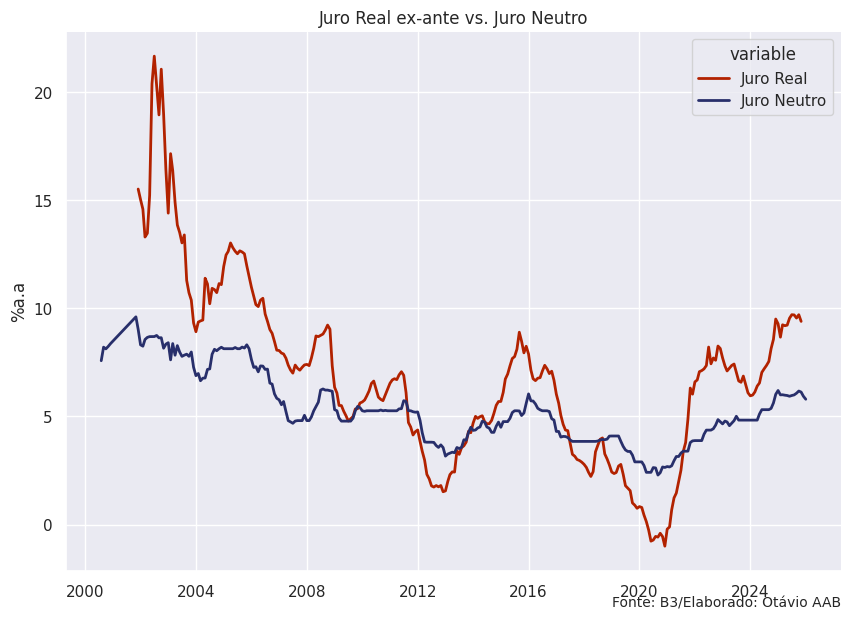

In [16]:
# Configura o tema do gráfico
sns.set()

theme = {'figure.figsize' : (10, 7),
         "axes.spines.right": False,
         "axes.spines.top": False}

# Cor das variáveis
colors = ['#b22200', '#282f6b']

# Adiciona as configurações
sns.set_theme(palette = colors,
              rc = theme)

# Plota
sns.lineplot(x = 'date', y = 'values',
            data = df_juros_long,
            hue = 'variable',
            linewidth = 2).set(xlabel = "",
                               ylabel = "%a.a",
                               title = "Juro Real ex-ante vs. Juro Neutro")

 # Adiciona a fonte no gráfico
plt.annotate('Fonte: B3/Elaborado: Otávio AAB',
            xy = (1.0, -0.06),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)

# Criação do Gráfico: opção 2

In [17]:
# Altera valores do índice de PeriodIndex para Datetime
ipca_expec_12m.index = ipca_expec_12m.index.to_timestamp()

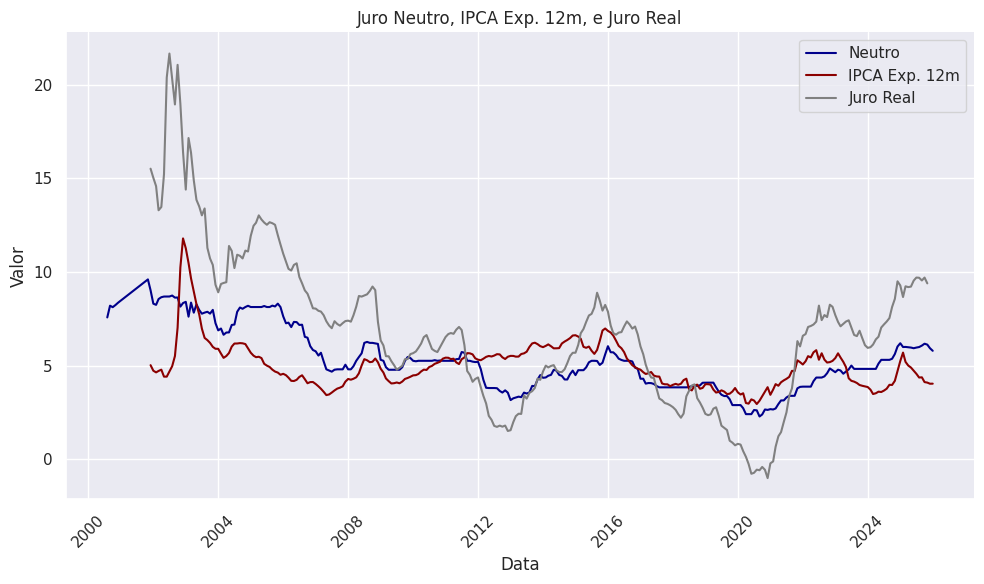

In [18]:
# Criação do gráfico
plt.figure(figsize=(10, 6))
plt.plot(proxy_neutro.index, proxy_neutro['neutro'], label='Neutro', color ='darkblue')
plt.plot(ipca_expec_12m.index, ipca_expec_12m['ipca_exp_12m'], label='IPCA Exp. 12m', color = 'darkred')
plt.plot(juro_real.index, juro_real['juro_real'], label='Juro Real', color = 'gray')

# Adicionar título e rótulos
plt.title('Juro Neutro, IPCA Exp. 12m, e Juro Real')
plt.xlabel('Data')
plt.ylabel('Valor')

# Exibir legenda
plt.legend()

# Melhorar a formatação das datas no eixo x
plt.xticks(rotation=45)

# Mostrar o gráfico
plt.tight_layout()
plt.show()